## Kuzushiji-49 Analysis
### Andrew Neilson-Mullins

## Task 1
### Loading the Data
We begin by importing the data and separating it into testing batches. Some initial data exploration is done to determine important features of the data which may effect later analysis

In [8]:
# Use pandas to load data
import pandas as pd
import numpy as np

# K49:
k49_test = pd.read_csv('D:/k49_Analysis/k49_test.csv', index_col = 0)
k49_train = pd.read_csv('D:/k49_Analysis/k49_train.csv', index_col = 0)

y_test = k49_test.pop('label').to_numpy()
X_test = k49_test.to_numpy()
print(y_test.shape)
print(X_test.shape)

y_train = k49_train.pop('label').to_numpy()
X_train = k49_train.to_numpy()
print(y_train.shape)
print(X_train.shape)

(38547,)
(38547, 784)
(232365,)
(232365, 784)


### Data Visualization
Next, we'll take a look at the cannonical characters we'll be using as labels, and then some features of the dataset.

In [107]:
char_df = pd.read_csv('D:/k49_Analysis/k49_classmap.csv', encoding = 'utf-8')

In [111]:
char_df.iloc[:, 2]

0     あ
1     い
2     う
3     え
4     お
5     か
6     き
7     く
8     け
9     こ
10    さ
11    し
12    す
13    せ
14    そ
15    た
16    ち
17    つ
18    て
19    と
20    な
21    に
22    ぬ
23    ね
24    の
25    は
26    ひ
27    ふ
28    へ
29    ほ
30    ま
31    み
32    む
33    め
34    も
35    や
36    ゆ
37    よ
38    ら
39    り
40    る
41    れ
42    ろ
43    わ
44    ゐ
45    ゑ
46    を
47    ん
48    ゝ
Name: char, dtype: object

Of course, the images we will actually classify are not in Unicode format, otherwise this project would be much easier! <br>
So, it is helpful to get a sample of what our classifier will actually be looking at. Below is a selection of 16 characters drawn at random from the dataset.

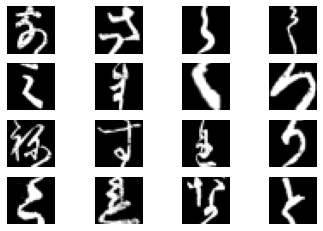

In [37]:
from matplotlib import pyplot as plt

sample_images = pd.DataFrame(X_train).sample(16).to_numpy()

fig, axes = plt.subplots(ncols = 4, nrows = 4)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        axes[i, j].imshow(sample_images[k].reshape([28, 28]), plt.get_cmap('gray'))
        axes[i, j].set_axis_off()
        k+=1

To get a feel for where our classifier might pick up some general features, especially when moving on to PCA, it may be helpful to look at a heatmap of the characters. In the image below, we can see that there are two primary "hotspots", where we might expect features to concentrate. <br>
We can also see that, because the dataset is split at random into training and testing data, there are very slight differences in their distribution.

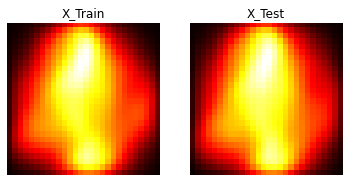

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols = 2)

ax1.imshow(X_train.sum(axis = 0).reshape([28, 28]), cmap = 'hot')
ax1.set_title('X_Train')
ax1.set_axis_off()

ax2.imshow(X_test.sum(axis = 0).reshape([28, 28]), cmap = 'hot')
ax2.set_title('X_Test')
ax2.set_axis_off()

Finally, we want to see how the characters are distributed by sample size. This particular dataset is unbalanced, and so some of the characters have many, many more samples than others. In fact, we can see that the character あ has over 10 times the representation of the character ゑ. <br>

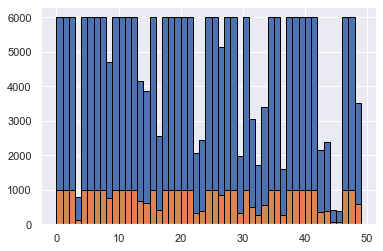

In [113]:
# Data visualization here
# For example, can print a sample of the cannonical glyphs, and some samples of each
from matplotlib import pyplot as plt

# plt.xticks(range(49), char_df.iloc[:, 2])
plt.hist(y_train, bins = range(0, 50), ec='black');
plt.hist(y_test, bins = range(0, 50), ec='black');

## Task 2
### Logistic Regression
Using logistic regression, we find a function which allows us to attempt to perform basic classification on the dataset. While this method is not especially accurate, it is still much better than chance, and can be used to gain insights for later testing.

In [21]:

class myLogisticRegression():
    """ Logistic Regression classifier -- this also works for the multiclass case.
    -----------
    Parameters:
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    
    """

    def __init__(self, learning_rate=.1):
        
        # learning rate can also be in the fit method
        self.learning_rate = learning_rate

    def fit(self, data, y, n_iterations = 1000, opt_method = 'SGD', size_batch = 20, num_epochs = 50):
        """ 
        Fit function : Uses labelled data to build a function which approximates a parameter.
        -----------
        Parameters:
        data : numpy array of shape (n_samples, m_variables)
            The observations to which we will fit a function
        y : Numpy array of shape (n_samples, )
            Data labels
        n_iterations : integer
            Number of iterations the gradient descent algorithm will accomplish
        opt_method : string
            Specifies whether gradient descent (GD) or stochastic GD (SGD) will be used
        size_batch : integer
            The number of parameters whose partial derivative will be calculated during each epoch
            in SGD
        num_epochs : integer
            The number of epochs the SGD algorithm will accomplish
        ----------
        Returns:
        self : Returns instance of self, with updated weights
        """
        
        self.opt_method = opt_method
        self.K = max(y)+1 # specify number of classes in y
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix
        eta = self.learning_rate
        
        W  = np.zeros((np.shape(X)[1],max(y)+1)) # initialize beta, can be other choices
        
        if self.opt_method == 'GD':
            for k in range(n_iterations):
                dW = self.loss_gradient(W,X,y) # write another function to compute gradient
                W = W - eta * dW # the formula of GD
                # this step is optional -- just for inspection purposes
                if k % 500 == 0: # print loss every 500 steps
                    print("loss after", k+1, "iterations is: ", self.loss(W,X,y))
        
        if self.opt_method == 'SGD':
            N = X.shape[0]
            self.num_epochs = num_epochs
            self.size_batch = size_batch
            num_iter = 0
            for e in range(num_epochs):
                shuffle_index = np.random.permutation(N) # in each epoch, we first reshuffle the data to create "randomness"
                for m in range(0,N,self.size_batch):   # m is the starting index of mini-batch
                    i = shuffle_index[m:m+self.size_batch] # index of samples in the mini-batch
                    dbeta = self.loss_gradient(W,X[i,:],y[i]) # only use the data in mini-batch to compute gradient. Note the average is taken in the loss_gradient function
                    W = W - eta * dbeta # the formula of GD, but this time dbeta is different
                    if e % 1 == 0 and num_iter % 5000 ==0: # print loss during the training process
                        print("loss after", e+1, "epochs and ", num_iter+1, "iterations is: ", self.loss(W,X,y))
                    num_iter += 1  # number of total iterations

        self.coeff = W
    

    def predict(self, data):
        """ 
        Using the fitted model, uses input data to construct a prediction of the output parameter
        ----------
        Parameters:
        data : numpy array of shape (n_samples, m_variables)
            The observations whose parameters will be used to predict an outcome
        ----------
        Output:
        y_pred : numpy array of shape (n_samples, )
            The output variable as predicted using the input
        """
        
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        W = self.coeff # the estimated W
        y_pred = np.argmax(self.sigma(X,W), axis =1) # the category with largest probability
        return y_pred

    def score(self, data, y_true):
        """ 
        Using the predict() method, compares predicted labels to the true label, and returns the mean number correct.
        ----------
        Parameters:
        data : numpy array of shape (n_samples, m_variables)
            The observations whose parameters will be used to predict an outcome
        y_true : numpy array of shape (n_samples, )
            Labels for each observation, to be compared to the predicted variable
        ----------
        Output:
        acc : float
            The number of correct predictions, compared to the number of total predicted variables
        """
        
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc

    def sigma(self,X,W): #return the softmax probability
        """ 
        Normalizes an array into a probability distribution
        ----------
        Parameters:
        X : numpy array of shape (n_samples, m_variables + 1)
            The augmented data matrix
        W : numpy array of shape (n_samples, m_variables + 1)
            Weights and intercept of the logistic regression function
        ----------
        Output:
        s/total : numpy array of shape (m_variables, 1)
            The normalized probability distribution
        """
        
        s = np.exp(np.matmul(X,W))
        total = np.sum(s, axis=1).reshape(-1,1)
        return s/total

    def loss(self,W,X,y):
        """ 
        Computed distance between observed sample probability distribution and modelled probability distribution;
        note this is for observation, and the loss for gradient descent is calculated in loss_gradient()
        ----------
        Parameters:
        X : numpy array of shape (n_samples, m_variables + 1)
            The augmented data matrix
        W : numpy array of shape (n_samples, m_variables + 1)
            Weights and intercept of the logistic regression function
        y : Numpy array of shape (n_samples, )
            Data labels
        ----------
        Output:
        -np.mean(loss_vector) : numpy array of shape(n_samples, )
            Mean of the entries of the loss vector            
        """
        
        f_value = self.sigma(X,W)
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) # avoid nan issues
        return -np.mean(loss_vector)

    def loss_gradient(self,W,X,y):
        """ 
        Computed distance between observed sample probability distribution and modelled probability distribution,
        in vector form. Used to calculate the direction of the local minimum
        ----------
        Parameters:
        X : numpy array of shape (n_samples, m_variables + 1)
            The augmented data matrix
        W : numpy array of shape (n_samples, m_variables + 1)
            Weights and intercept of the logistic regression function
        y : Numpy array of shape (n_samples, )
            Data labels
        ----------
        Output:
        dLdW : numpy array of shape (m_variables, )
            Direction of the local maximum, which is then subtracted from W to iterate toward the local minimum
        """
        
        f_value = self.sigma(X,W)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X # Numpy broadcasting
            dLdW[:,k] = np.mean(dLdWk, axis=0)   # RHS is 1D Numpy array -- so you can safely put it in the k-th column of 2D array dLdW
        return dLdW

In [22]:
learning_rate = 0.000001 # Higher learning rates were not numerically stable
k49_classifier = myLogisticRegression(learning_rate)

In [25]:
k49_classifier.fit(X_train, y_train, num_epochs = 15, size_batch = 25, opt_method = 'SGD');

loss after 1 epochs and  1 iterations is:  3.867532357435851
loss after 1 epochs and  5001 iterations is:  1.3847010769058599
loss after 2 epochs and  10001 iterations is:  1.3329009509643592
loss after 2 epochs and  15001 iterations is:  1.3065459392547802
loss after 3 epochs and  20001 iterations is:  1.3017002681611405
loss after 3 epochs and  25001 iterations is:  1.2900909963427944
loss after 4 epochs and  30001 iterations is:  1.300318257762864
loss after 4 epochs and  35001 iterations is:  1.2794947555776217
loss after 5 epochs and  40001 iterations is:  1.2730974868873968
loss after 5 epochs and  45001 iterations is:  1.2723053985784762
loss after 6 epochs and  50001 iterations is:  1.274104587066321
loss after 6 epochs and  55001 iterations is:  1.2694330059912802
loss after 7 epochs and  60001 iterations is:  1.2637809506002888
loss after 7 epochs and  65001 iterations is:  1.2638301890103734
loss after 8 epochs and  70001 iterations is:  1.2630487333427185
loss after 9 epoch

Since our dataset has a very lopsided number of examples for certain classes, we want to define a new metric for judging accuracy. Here we use an implementation of balanced accuracy provided by those who gathered the original data. The implementation iterates through each character, and tests how well it was predicted by the model. We can look at these individually to judge our model's performance at a more granular level, or take their average to get a better idea of how the model as a whole performs.

In [26]:
p_test = k49_classifier.predict(X_test)

accs = []
for cls in range(49):
    mask = (y_test == cls)
    cls_acc = (p_test == cls)[mask].mean() # Accuracy for rows of class cls
    accs.append(cls_acc)
print(accs)
accs_mean = np.mean(accs) # Final balanced accuracy
print(accs_mean)
print(k49_classifier.score(X_test, y_test))

[0.643, 0.796, 0.841, 0.4603174603174603, 0.659, 0.325, 0.488, 0.697, 0.39504563233376794, 0.565, 0.65, 0.628, 0.442, 0.5383480825958702, 0.46740858505564387, 0.438, 0.7727272727272727, 0.604, 0.775, 0.597, 0.452, 0.528, 0.5654761904761905, 0.46115288220551376, 0.637, 0.418, 0.6854066985645934, 0.643, 0.72, 0.37962962962962965, 0.522, 0.42771084337349397, 0.7071428571428572, 0.5271739130434783, 0.51, 0.447, 0.49230769230769234, 0.847, 0.569, 0.423, 0.455, 0.51, 0.5919540229885057, 0.3282051282051282, 0.29411764705882354, 0.4375, 0.674, 0.847, 0.4547038327526132]
0.5578842524648681
0.5768542299011596


Note here that our new accuracy metric, while a bit lower than the one in our original function, is still fairly high. <br>
Looking at the accuracy per character, we see that for some, the model predicted quite well; even getting to nearly 90% in some cases. We might expect that the more samples we have of a character, the better chance we have of predicting it correctly. As we can see in the following figure, this does seem to be the case. However, the R^2 is somewhat low, and so there is not as great a correlation as one might think.

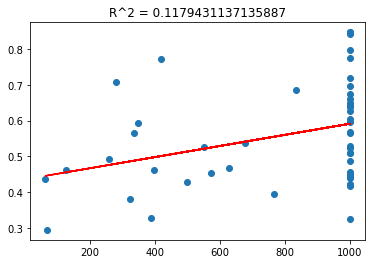

In [36]:
from matplotlib import pyplot as plt
m,b = np.polyfit(sample_count, accs, 1)
R_squared = np.corrcoef(sample_count, accs)[0, 1]**2
sample_count = np.bincount(y_test)
plt.scatter(sample_count, accs)
plt.plot(sample_count, m*sample_count + b, 'r')
plt.title("R^2 = {r}".format(r = R_squared))
plt.show()

## Task 3
### Principal Component Analysis
Next, we want to perform principal component analysis, in order to reduce the dimensionality of the data. This will help with a few things. Most notably in this paper, when we later perform k-NN classification, it will significantly speed up the testing time.

In [10]:
class myPCA():
    """
    Principal Component Analysis 
        Performs demension reduction via singular value decomposition, obtaining the first n eigenvectors (specified)
    """
    
    def __init__(self, n_components = 2):
        """
        Parameters:
        n_components : int
            Specifies that the model should keep the first n eigenvectors
        """
        self.n_c = n_components
    
    
    def fit(self,X):
        """
        Fit the model with the input data
        -----------
        Parameters:
        X : numpy array of shape (n_samples, m_variables)
            Training data
        ----------
        Returns:
        self : Returns instance of self
        """
        cov_mat = np.cov(X.T) # covariance matrix, the input matrix to this function does not need to be centered
        eig_val, eig_vec = np.linalg.eigh(cov_mat) #eigen-values and orthogonal eigen-vectors --ascending order
        eig_val = np.flip(eig_val) # reverse the order --descending
        eig_vec = np.flip(eig_vec,axis=1) # reverse the order
        self.eig_values = eig_val[:self.n_c] # select the top eigen-vals
        self.principle_components = eig_vec[:,:self.n_c] # select the top eigen-vecs
        self.variance_ratio = self.eig_values/eig_val.sum() # variance explained by each PC
    
    def transform(self,X):
        """
        Apply dimensionality reduction on X
        ----------
        Parameters:
        X : numpy array of shape (n_samples, m_variables)
            Data upon which dimensionality reduction will be performed
        ----------
        Returns:
        X : numpy array of shape (n_samples, n_components)
            The data matrix projected onto the lower dimension
        """
        return np.matmul(X-X.mean(axis = 0),self.principle_components) #project the data (centered) on PCs

In [11]:
pca = myPCA(n_components = 16)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

Visualizing these principal components gives us an interesting glimpse into what it is that "makes up" each character. Recall from above that the character heatmap showed two points of high activity, through which strokes of the characters pass frequently. <br>
This might give us the idea that concentrating on these areas might give more insight into the type of character. <br>
Looking at the principal components below, we can build upon this intution. The characters whose strokes pass through the lighter areas, as before, can increasingly be correlated with some specific output.

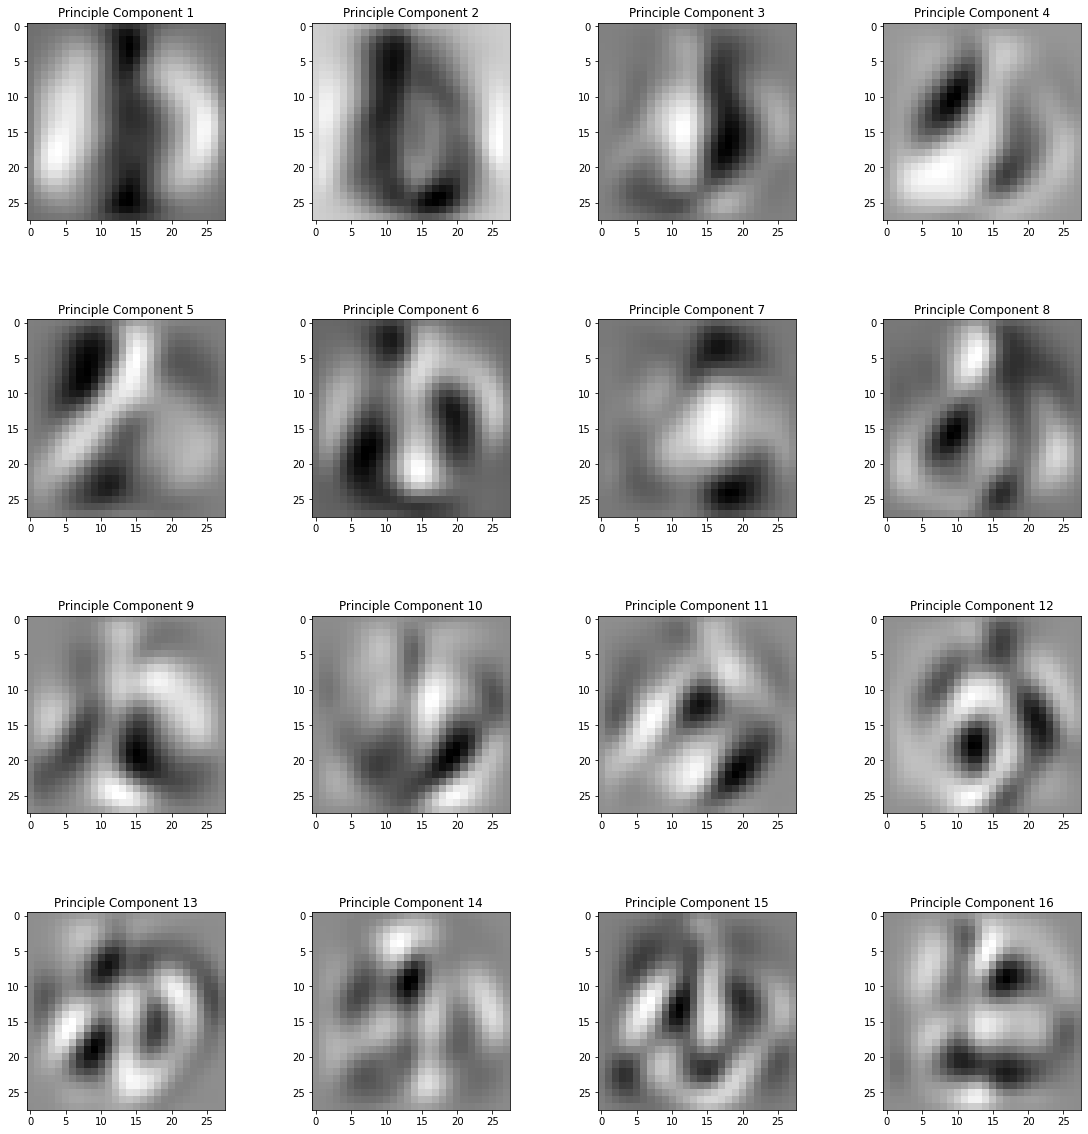

In [14]:
from matplotlib import pyplot as plt 

fig, axs = plt.subplots(4,4, figsize=(20, 20))
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()
for i in range(16):
    axs[i].imshow(pca.principle_components[:,i].reshape(28,28),cmap=plt.cm.gray)
    axs[i].set_title('Principle Component '+str(i+1))

Now that we've reduced the number of parameters from 28x28 to just 16, we can more easily visualize the correlation between any two parameters. For example, when comparing the first two principal components against each other, we can start to see that many similar characters form clusters, even if the edges of these are not very well-defined.

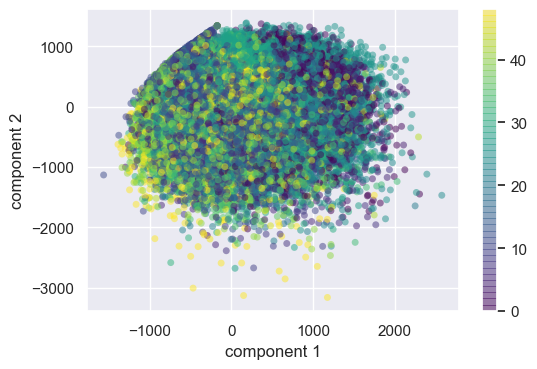

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
figure = plt.figure(dpi=100)
plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1],c=y_test, s=25, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('viridis', 49))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### K-NN Classification with PCA
The default sklearn KNN Classifier uses the Minkowski metric, defined as: <br>
$$ D(X,Y) = \left(\sum_{i=1}^{n} |x_i - y_i|^p\right)^\frac{1}{p} $$
The model uses this to measure the distance between a point and its neighbors, allowing it to identify elements in the space which share, or are close to sharing, common features. During prediction, it iterates through points in the space, comparing their components to the test element. These points then "vote" for which class is the most likely, by computing the fraction of neighbors belonging to that class, using the formula:
$$ P\left(y = j|x\right) \approx \frac{1}{k} \sum_{i\in \mathcal{N}_x} \{y^{(i)}=j\} $$


While fitting the model is relatively quick, prediction takes considerably longer, due primarily in this case to the high dimensionality of the data. Thus, using the PCA we've already performed, we reduce the dimensionality from 28x28 to just 16, achieving a much quicker runtime at decent accuracy.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 20)
knn_clf.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=20)

In [8]:
knn_clf.score(X_pca,y_test)

0.7702804368692765

### K-Means Clustering
K-means clustering seeks to partition the data set into groups, such that the loss function is minimized. This loss function is given by:
$$ \min_S \sum_{i=1}^{K} \sum_{x\in S_i} || x - \mu_i ||^2 $$
This function is the sum of squares of the distance between objects in the cluster. <br>
Dimension reduction was attempted, but proved to result in very low correlation between clusters and actual labels.
However, allowing the model to train on the unreduced dataset allowed us to take an extra visualization step. We were able to, using the cluster_centers_ method, visualize the model's prediction of a "cannonical member" of each cluster. Similar to the PCA visualization, this allows us to get an idea of what exactly it is the model considers a member of each class. <br>

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=49, random_state=0)
y_km = kmeans.fit_predict(X_train)

In [53]:
centroids = kmeans.cluster_centers_
print(centroids.shape)
images = centroids.reshape(49, 28, 28)
images.shape

(49, 784)


(49, 28, 28)

<ipython-input-54-ece5c65b3f27>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


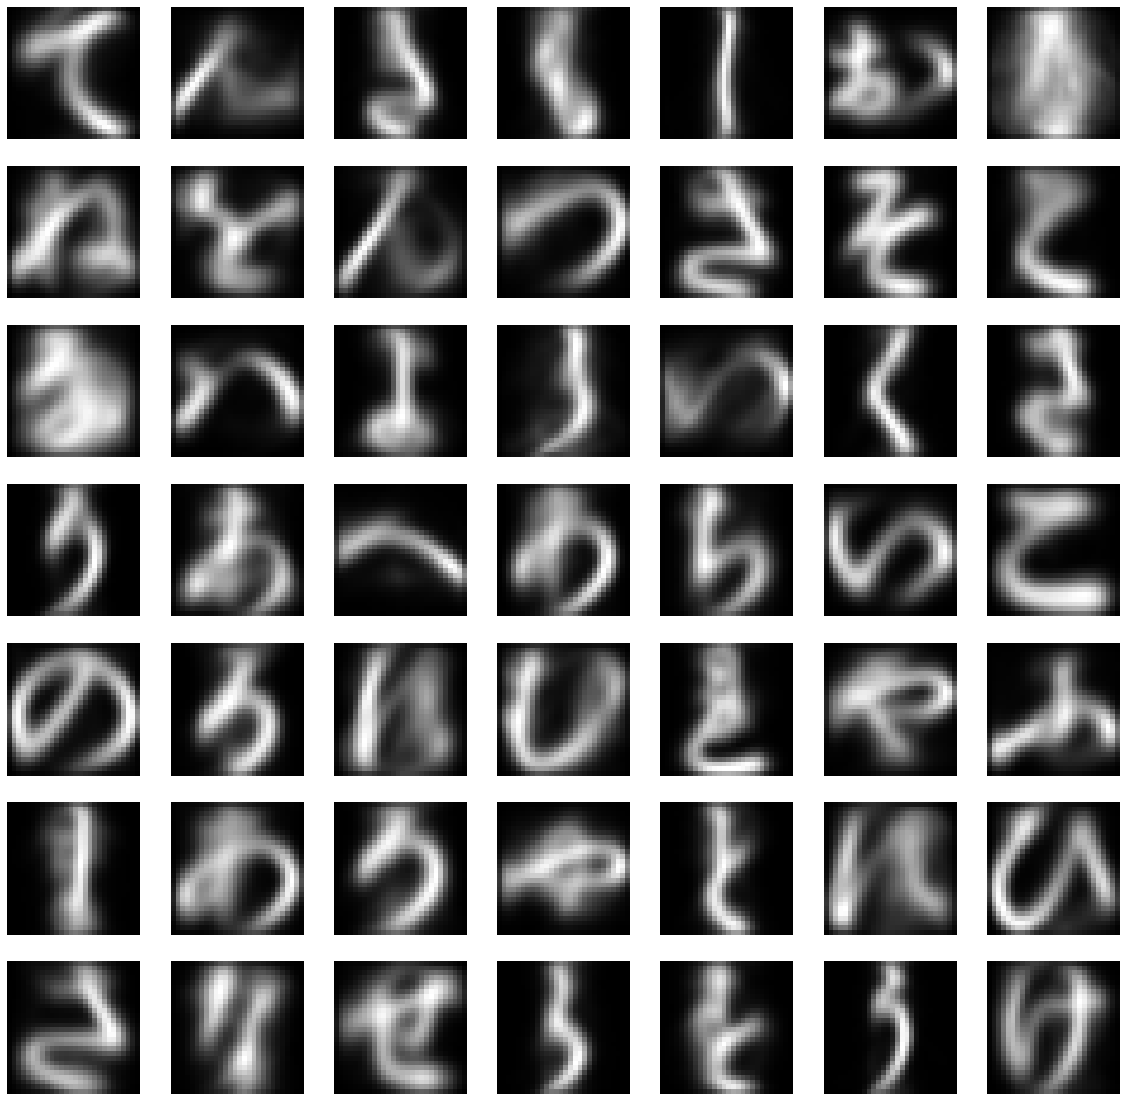

In [54]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(7, 7,  figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

While PCA was not performed when fitting the model, it is still very useful to do for cluster visualization. <br>
As we can see in the graph below, while the model does seem to be able to pick out certain clusters, it does not seem to properly cluster the characters together.

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

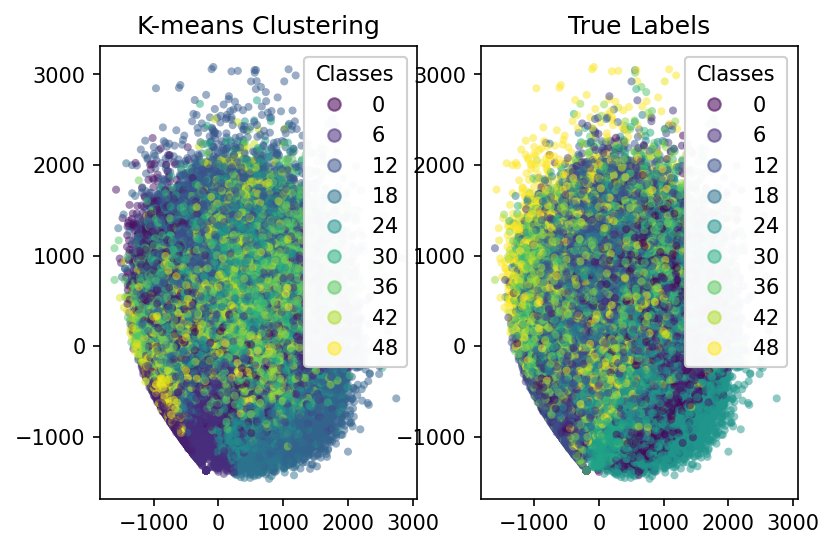

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2,dpi=150)

fig1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1],c=y_km, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('viridis', 49))
fig2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1],c=y_train, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('viridis', 49))
ax1.set_title('K-means Clustering')
legend1 = ax1.legend(*fig1.legend_elements(), loc="best", title="Classes")
ax1.add_artist(legend1)
ax2.set_title('True Labels')
legend2 = ax2.legend(*fig2.legend_elements(), loc="best", title="Classes")
ax2.add_artist(legend2)

In [52]:
from sklearn import metrics
metrics.adjusted_rand_score(y_km, y_train)

0.24211814336868598

The adjusted_rand_score metric in sklearn computes a similarity measure between two clusterings by considering all pairs of samples, and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings, according to the documentation. Thus we can use it to get an idea of how accurate our model really is at recognizing characters. The score shows that the model certainly performs better than chance, but 24% is not terribly high considering the other methods we may have access to.

### Tensorflow
A very bare-bones implementation of a tensorflow neural network, with just one hidden layer. <br>
The model performed passably, with an accuracy of 40%.

In [6]:
import tensorflow as tf

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(49)])

predictions = model(X_train).numpy()
tf.nn.softmax(predictions).numpy()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train, predictions).numpy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [10]:
model.fit(X_train, y_train, epochs = 10)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose = 2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
7262/7262 [==============================] - 10s 1ms/step - loss: 3.2590 - accuracy: 0.2972
Epoch 2/10
7262/7262 [==============================] - 10s 1ms/step - loss: 2.2567 - accuracy: 0.4274
Epoch 3/10
7262/7262 [==============================] - 11s 1ms/step - loss: 2.0868 - accuracy: 0.4606
Epoch 4/10
7262/7262 [==============================] - 11s 1ms/step - loss: 2.0099 - accuracy: 0.4834
Epoch 5/10
7262/7262 [==============================] - 14s 2ms/step - loss: 1.9795 - accuracy: 0.4914
Epoch 6/10
7262/7262 [==============================] - 11s 1ms/step - loss: 1.9447 - accuracy: 0.4999
Epoch 7/10
7262/7262 [==============================] - 10s 1ms/step - loss: 1.9282 - accuracy: 0.5055
Epoch 8/10
7262/7262 [==============================] - 10s 1ms/step - loss: 1.9701 - accuracy: 0.4925
Epoch 9/10
7262/7262 [==============================] - 9s 1ms/step - loss: 1.9563 - accuracy: 0.4951
Epoch 10/10
7262/7262 [==============================] - 11s 1ms/step - lo

In [11]:
model.evaluate(X_test, y_test, verbose = 2)

1205/1205 - 1s - loss: 2.7075 - accuracy: 0.4084


[2.7075295448303223, 0.40841051936149597]